In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
rutas_gdf = gpd.read_file('/home/edgar/SIG/ObsCds/'+
                          'Proyectos/Museo_CienciasAmbientales'+
                          '/Medio_Urbano/Transporte_Publico/'+
                          'Ruta400m_LomasDelCentinela_MCA_ITESM22_UTM_v1.geojson',
                         driver='GeoJSON')
paradas_gdf = gpd.read_file('/home/edgar/SIG/ObsCds/'+
                          'Proyectos/Museo_CienciasAmbientales'+
                          '/Medio_Urbano/Transporte_Publico/'+
                            'ParadasRuta400m_LomasDelCentinela_MCA_ITESM22_UTM_v1.geojson',
                         driver='GeoJSON')

In [3]:
print(rutas_gdf.shape)
rutas_gdf.head(2)

(12, 3)


,fid,cat,geometry
0,1,1,"LINESTRING (668812.682 2294039.439, 668850.215..."
1,2,1,"LINESTRING (668890.039 2294405.657, 668894.307..."


In [4]:
print(paradas_gdf.shape)
paradas_gdf.head(2)

(13, 5)


,fid,cat,fid_2,cat_2,geometry
0,1.0,1.0,2.0,1.0,POINT (668890.039 2294405.657)
1,2.0,1.0,3.0,1.0,POINT (668982.942 2294765.483)


In [5]:
import osmnx as ox

In [6]:
edges = gpd.read_file('/home/edgar/SIG/ObsCds/Proyectos/Museo_CienciasAmbientales/Medio_Urbano/Vias_Transporte/edges_speed_AMG.geojson', driver='GeoJSON')
print(edges.shape)
edges.head(2)

(414773, 16)


,id,u,v,key,osmid,oneway,length,grade,grade_abs,bridge,junction,service,tunnel,walkspeed,time_min,geometry
0,-1.922695e+09,1.680913e+09,1.680913e+09,0.0,155732288,False,45.603,0.022,0.022,None,None,None,None,3.703559,0.738797,"LINESTRING (-103.25834 20.68905, -103.25844 20..."
1,-1.922105e+09,4.343498e+09,4.343498e+09,0.0,436461417,False,141.661,0.042,0.042,None,None,None,None,3.453176,2.461404,"LINESTRING (-103.19724 20.66496, -103.19742 20..."


In [25]:
idx = edges.u.isna()
edges = edges.loc[~idx]
idx = edges.v.isna()
edges = edges.loc[~idx]

In [7]:
nodes = gpd.read_file('/home/edgar/SIG/ObsCds/Proyectos/Museo_CienciasAmbientales/Medio_Urbano/Vias_Transporte/nodes_AMG.geojson', driver='GeoJSON')
print(nodes.shape)
nodes.head(2)

(172090, 5)


,osmid,x,y,street_count,geometry
0,28751344,-103.306309,20.711533,3.0,POINT (-103.30631 20.71153)
1,28753224,-103.316645,20.700650,3.0,POINT (-103.31665 20.70065)


In [8]:
G = ox.graph_from_gdfs(nodes.set_index('osmid'), edges.set_index(['u','v','key']))

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/osmnx/utils_graph.py:155: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


In [34]:
paradas_gdf = paradas_gdf.to_crs("EPSG:4326")
paradas_osmid = aup.find_nearest(G, nodes.set_index('osmid'), paradas_gdf, return_distance= True)
print(paradas_osmid.shape)
paradas_osmid.head(2)

(13, 7)


,fid,cat,fid_2,cat_2,geometry,osmid,distance_node
0,1.0,1.0,2.0,1.0,POINT (-103.37788 20.74168),1945345211,20.955469
1,2.0,1.0,3.0,1.0,POINT (-103.37696 20.74492),1689004521,39.486632


In [35]:
paradas_dist = aup.calculate_distance_nearest_poi(paradas_osmid, nodes.set_index('osmid'), 
                edges.set_index(['u','v','key']), 'parada', 'osmid', wght='time_min')

In [36]:
paradas_dist.loc[paradas_dist.dist_parada<=15]

,x,y,street_count,geometry,dist_parada
osmid,,,,,
960922318,-103.379216,20.735972,3.0,POINT (-103.37922 20.73597),3.804792
1180211158,-103.379289,20.749854,1.0,POINT (-103.37929 20.74985),14.675713
1380480800,-103.382586,20.732598,3.0,POINT (-103.38259 20.73260),13.009162
1514364069,-103.376040,20.734786,4.0,POINT (-103.37604 20.73479),9.922780
1624212739,-103.381845,20.732342,3.0,POINT (-103.38184 20.73234),14.300416
...,...,...,...,...,...
8821632141,-103.373730,20.748891,3.0,POINT (-103.37373 20.74889),6.646185
8821632142,-103.373221,20.748718,3.0,POINT (-103.37322 20.74872),5.553961
8821632156,-103.372836,20.750636,4.0,POINT (-103.37284 20.75064),4.490105


<AxesSubplot:>

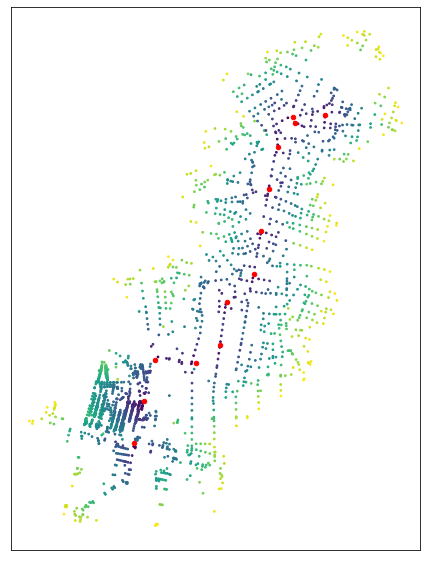

In [45]:
fig,ax = plt.subplots(figsize=(10,10))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

paradas_osmid.plot(color='red', markersize=20, ax=ax, zorder=2)
paradas_dist.loc[paradas_dist.dist_parada<=15].plot('dist_parada', markersize=3, ax=ax)

(220, 2)


<AxesSubplot:>

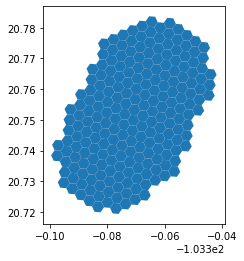

In [54]:
res = 9
buffer_ruta = gpd.GeoDataFrame(rutas_gdf.buffer(2000).to_crs("EPSG:4326"))
buffer_ruta = buffer_ruta.rename(columns={0:'geometry'})
hex_gdf = aup.create_hexgrid(buffer_ruta, res)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(hex_gdf.shape)
hex_gdf.plot()

In [58]:
hex_time = aup.group_by_hex_mean(paradas_dist.reset_index(), hex_gdf, 9, 'dist_parada')
print(hex_time.shape)
hex_time.head(4)

(220, 6)


,hex_id_9,geometry,x,y,street_count,dist_parada
0,89498c9490fffff,"POLYGON ((-103.36938 20.75489, -103.36816 20.7...",-103.370512,20.756784,3.285714,7.553768
1,89498c948afffff,"POLYGON ((-103.35814 20.74022, -103.35692 20.7...",-103.358931,20.741588,2.450000,26.814827
2,8949ab4b26fffff,"POLYGON ((-103.38863 20.75304, -103.38741 20.7...",-103.389186,20.754612,2.775000,34.190455
3,89498c94d87ffff,"POLYGON ((-103.37907 20.72134, -103.37786 20.7...",-103.379919,20.723082,3.750000,34.307661


<AxesSubplot:>

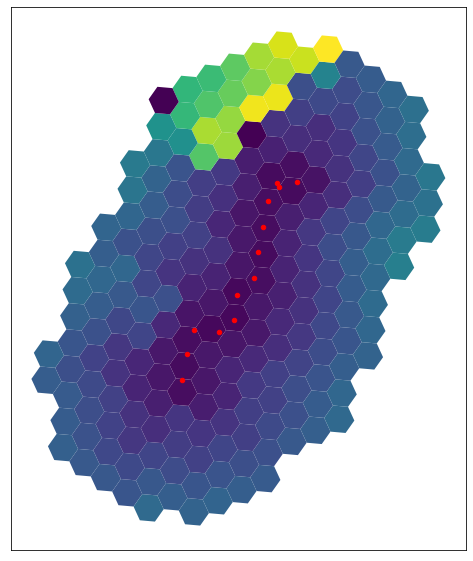

In [60]:
fig,ax = plt.subplots(figsize=(10,10))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

paradas_osmid.plot(color='red', markersize=20, ax=ax, zorder=2)
hex_time.plot('dist_parada', ax=ax)

In [63]:
hex_time.to_file('/home/edgar/SIG/ObsCds/Proyectos/'+
                        'Museo_CienciasAmbientales/Medio_Urbano/Analisis/'+
                        'HexCobertura_RutaLomasCentinela_v1.geojson',
                    driver='GeoJSON')

In [62]:
paradas_dist.loc[paradas_dist.dist_parada<=30].to_file('/home/edgar/SIG/ObsCds/Proyectos/'+
                        'Museo_CienciasAmbientales/Medio_Urbano/Analisis/'+
                        'NodosDistanciaParada_RutaLomasCentinela_v1.geojson',
                    driver='GeoJSON')

In [64]:
block = gpd.read_file('/home/edgar/SIG/Info_Grl/'+
                      'Info_Sociodemografica/Censo/2020/'+
                      'CntMnzCPyV_AMG_INEGI20_UTM_v1.shp', driver='ESRIShapefile')
print(block.shape)
block.head(2)

(60121, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,field_1,ENTIDAD,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCIN,VPH_SINTIC,geometry
0,1400900690031005,14,009,0069,0031,005,Rural,Típica,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (643034.793 2291337.416)
1,1400900060243020,14,009,0006,0243,020,Urbana,Típica,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (642012.719 2294073.386)


In [66]:
hex_group = hex_time.loc[hex_time.dist_parada<=10]
hex_group = hex_group[['hex_id_9','geometry']].copy()
print(hex_group.shape)
hex_group.head(2)

(33, 2)


,hex_id_9,geometry
0,89498c9490fffff,"POLYGON ((-103.36938 20.75489, -103.36816 20.7..."
5,89498c94993ffff,"POLYGON ((-103.37406 20.73982, -103.37284 20.7..."


In [88]:
block.columns.to_list()

['cvegeo',
 'cve_ent',
 'cve_mun',
 'cve_loc',
 'cve_ageb',
 'cve_mza',
 'ambito',
 'tipomza',
 'field_1',
 'entidad',
 'nom_ent',
 'mun',
 'nom_mun',
 'loc',
 'nom_loc',
 'ageb',
 'mza',
 'pobtot',
 'pobfem',
 'pobmas',
 'p_0a2',
 'p_0a2_f',
 'p_0a2_m',
 'p_3ymas',
 'p_3ymas_f',
 'p_3ymas_m',
 'p_5ymas',
 'p_5ymas_f',
 'p_5ymas_m',
 'p_12ymas',
 'p_12ymas_f',
 'p_12ymas_m',
 'p_15ymas',
 'p_15ymas_f',
 'p_15ymas_m',
 'p_18ymas',
 'p_18ymas_f',
 'p_18ymas_m',
 'p_3a5',
 'p_3a5_f',
 'p_3a5_m',
 'p_6a11',
 'p_6a11_f',
 'p_6a11_m',
 'p_8a14',
 'p_8a14_f',
 'p_8a14_m',
 'p_12a14',
 'p_12a14_f',
 'p_12a14_m',
 'p_15a17',
 'p_15a17_f',
 'p_15a17_m',
 'p_18a24',
 'p_18a24_f',
 'p_18a24_m',
 'p_15a49_f',
 'p_60ymas',
 'p_60ymas_f',
 'p_60ymas_m',
 'rel_h_m',
 'pob0_14',
 'pob15_64',
 'pob65_mas',
 'prom_hnv',
 'pnacent',
 'pnacent_f',
 'pnacent_m',
 'pnacoe',
 'pnacoe_f',
 'pnacoe_m',
 'pres2015',
 'pres2015_f',
 'pres2015_m',
 'presoe15',
 'presoe15_f',
 'presoe15_m',
 'p3ym_hli',
 'p3ym_hli_

In [107]:
block = block.to_crs("EPSG:4326")
block.columns = map(str.lower, block.columns)
socio_columns = ['pobtot','pobfem','pobmas','p_0a2',
                 'p_3a5','p_6a11','p_12a14','p_15a17','p_18a24',
                 'p_18ymas','p_60ymas','vivtot','tvivparhab',
                 'vivpar_des','tothog','hogjef_f','geometry']
hex_pop = aup.socio_points_to_polygon(hex_group, block[socio_columns],'hex_id_9',
                                     string_columns=[])

In [108]:
hex_pop.pobtot.sum()

20786.0

<AxesSubplot:>

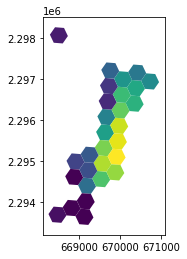

In [109]:
hex_mrg = hex_gdf.merge(hex_pop, on='hex_id_9')
hex_mrg = hex_mrg.to_crs("EPSG:32613")
hex_mrg['dens_pobha'] = hex_mrg.pobtot / (hex_mrg.area / 10000)
hex_mrg.plot('dens_pobha', 'viridis')

In [110]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [111]:
query = f"SELECT * FROM censo.nodes_marg_2020 WHERE (ST_Intersects(geometry, \'SRID=4326; {poly_wkt}\'))"
nodes_marg = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes_marg.shape)
nodes_marg.head(2)

(7023, 31)


,x,y,street_count,geometry,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,CVE_AGEB,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,-103.390163,20.729463,0,POINT (-103.39016 20.72946),1412000011009,14,120,0001,1009,1412000011009,...,0.0,0.0,0.0,0.0,0.0,0.065945,0.01293,0.041377,123.6562,0.965956
1,-103.390221,20.728953,0,POINT (-103.39022 20.72895),1412000011009,14,120,0001,1009,1412000011009,...,0.0,0.0,0.0,0.0,0.0,0.065945,0.01293,0.041377,123.6562,0.965956


<AxesSubplot:>

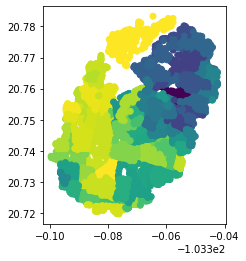

In [112]:
nodes_marg.plot('im_2020')

In [113]:
avg_column = [
    "imn_2020",
    "im_2020",
]
# sum data for weighted averaged
avg_dict = {
    "imn_2020":"pobtot",
    "im_2020":"pobtot",
}

string_columns = []

In [114]:
hex_group = hex_group.to_crs("EPSG:4326")

hex_marg = aup.socio_points_to_polygon(hex_group, nodes_marg[['pobtot','imn_2020',
                                                             'im_2020','geometry']],
                                        'hex_id_9',
                                     string_columns=[],
                                       wgt_dict=avg_dict,
                                       avg_column=avg_column)
hex_marg.drop(columns='pobtot', inplace=True)

In [115]:
hex_socio = hex_mrg.merge(hex_marg, on='hex_id_9')
print(hex_socio.shape)
hex_socio.head(2)

(28, 21)


,hex_id_9,geometry,pobtot,pobfem,pobmas,p_0a2,p_3a5,p_6a11,p_12a14,p_15a17,...,p_18ymas,p_60ymas,vivtot,tvivparhab,vivpar_des,tothog,hogjef_f,dens_pobha,imn_2020,im_2020
0,89498c9490fffff,"POLYGON ((669760.776 2295877.063, 669886.017 2...",393.0,167.0,178.0,-12.0,-10.0,30.0,-6.0,3.0,...,231.0,19.0,123.0,89.0,0.0,89.0,5.0,31.498239,0.972287,124.46669
1,89498c94993ffff,"POLYGON ((669290.411 2294203.919, 669415.651 2...",354.0,200.0,154.0,12.0,17.0,30.0,13.0,24.0,...,258.0,40.0,96.0,92.0,3.0,92.0,40.0,28.373627,0.966689,123.750034


<AxesSubplot:>

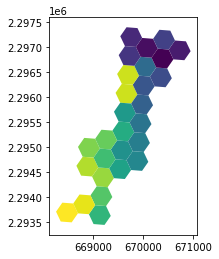

In [116]:
hex_socio.plot("im_2020", "viridis")

In [117]:
marg_limits = {'Muy alto':[115.212, 53.445],
'Alto':[118.609,115.212],
'Medio':[121.157, 118.609],
'Bajo':[123.705, 121.157],
'Muy bajo':[127.951, 123.705]}


#nse to hex bins
hex_socio['gm_2020'] = np.nan
for n in list(marg_limits.keys()):
    upper_marg = marg_limits[n][0]
    lower_marg = marg_limits[n][1]
    hex_socio.loc[(hex_socio['im_2020']>lower_marg)&
                (hex_socio['im_2020']<=upper_marg),'gm_2020'] = n

In [119]:
type_dict = {'string':['hex_id_9','gm_2020'],
             'integer':['pobtot','pobfem','pobmas','p_0a2',
                 'p_3a5','p_6a11','p_12a14','p_15a17','p_18a24',
                 'p_18ymas','p_60ymas','vivtot','tvivparhab',
                 'vivpar_des','tothog','hogjef_f'],
             'float':['im_2020','imn_2020']  
}
hex_socio = aup.convert_type(hex_socio, type_dict)

In [120]:
hex_socio.to_file('/home/edgar/SIG/ObsCds/'+
                   'Proyectos/Museo_CienciasAmbientales/Info_Sociodemografica/'+
                   'hexSocio_10min_RutasLomasCentinela_v1.geojson',
                    driver='GeoJSON')